<a href="https://colab.research.google.com/github/JonasVerbickas/test-jupyter/blob/main/NLP_CW2_Task_2_(torch_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
import os
import re
import pandas as pd
import collections
import random
import torch
from torchsummary import summary
from torchtext.vocab import build_vocab_from_iterator
from gensim.models import Word2Vec, FastText
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# 1. Preprocessing/Cleaning

In [2]:
USE_STEMMING_INSTEAD_OF_LEMMATIZATION = False

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
if USE_STEMMING_INSTEAD_OF_LEMMATIZATION:
  token_processing_fn = nltk.PorterStemmer().stem 
else:
  token_processing_fn = nltk.stem.WordNetLemmatizer().lemmatize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
def create_concat_text_content_string(path_to_dataset):
  file_contents = ""
  for filename in os.listdir(path_to_dataset):
    # skip readme
    if filename in ['README.txt', 'ipod']:
      continue
    # append contents of other files to file_contents string
    starting_corpus_size = len(file_contents)
    with open(os.path.join(path_to_dataset, filename)) as f:
      file_contents += f.read()
    print("After appending", filename, "corpus sized increased to", starting_corpus_size, "->", len(file_contents))
  return file_contents

In [5]:
def removeAnnotationSymbols(sentence):
  static_removals = ['[t]', '[u]','[p]','[s]','[cc]','[cs]']
  for symbol in static_removals:
    sentence = sentence.replace(symbol, '')
  return sentence

In [6]:
def calculateSentement(unprocessed_sentence):
  semantic_tokens = re.findall('\[([+-]\d)\]', unprocessed_sentence)
  semantic_sum = 0
  for token in semantic_tokens:
    semantic_sum += int(token)
  return semantic_sum

In [7]:
def process_string_of_reviews_into_df(string_of_reviews):
  """
  1. Apply casefolding
  2. Expand contractions
  3. Tokenize sentances
  4. Ignore stop-words
  5. Ignore tokens that don't contain any alphanumeric characters
  6. Ignore sentiment analysis tokens e.g. `+3`
  """
  list_of_reviews = string_of_reviews.split("[t]\n")
  tokenized_sentence_sentiment_list = []
  for review in list_of_reviews:
    sentiment = 0
    processed_review = []
    review_split_into_lines = review.split('\n')
    for line in review_split_into_lines:
      sentiment_tags, _, sentence = line.partition("##")
      sentiment += calculateSentement(sentiment_tags)
      x = removeAnnotationSymbols(sentence)
      x = x.casefold()
      # processed_review = f"{processed_review} {x}"
      x = nltk.tokenize.word_tokenize(x)
      processed_review += x
    tokenized_sentence_sentiment_list.append([review, processed_review, sentiment])
  df = pd.DataFrame(tokenized_sentence_sentiment_list, columns=['original review','processed review','sentiment'])
  return df


In [8]:
class ReviewDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_review_folder):
        string_of_reviews = create_concat_text_content_string(path_to_review_folder)
        self.review_df = process_string_of_reviews_into_df(string_of_reviews)
        set_of_all_tokens = set([token for review in self.review_df['processed review'] for token in review])
        print(f"{len(set_of_all_tokens)=}")
        print(f"{len(set_of_all_tokens)=}")
        # bug
        # self.vocab = build_vocab_from_iterator(yield_tokens(set_of_all_tokens))
        self.vocab = build_vocab_from_iterator([set_of_all_tokens], max_tokens=len(set_of_all_tokens), specials=["<unk>"])
        print(f"{len(self.vocab)=}")
        self.vocab.set_default_index(self.vocab["<unk>"])
        
  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, idx):
    review = self.review_df.iloc[idx]
    return self.vocab(list(review["processed review"])), review['sentiment']


In [9]:
PATH_TO_REVIEWS = "/content/drive/MyDrive/Colab Notebooks/product_reviews"
dataset = ReviewDataset(PATH_TO_REVIEWS)
dataset[6]

After appending Nokia_6600.txt corpus sized increased to 0 -> 56093
After appending norton.txt corpus sized increased to 56093 -> 95013
After appending Linksys_Router.txt corpus sized increased to 95013 -> 151947
After appending MicroMP3.txt corpus sized increased to 151947 -> 259727
After appending Diaper_Champ.txt corpus sized increased to 259727 -> 294831
After appending Hitachi_router.txt corpus sized increased to 294831 -> 325078
After appending Canon_S100.txt corpus sized increased to 325078 -> 353887
After appending Canon_PowerShot_SD500.txt corpus sized increased to 353887 -> 378520
After appending ipod.txt corpus sized increased to 378520 -> 436566
len(set_of_all_tokens)=6569
len(set_of_all_tokens)=6569
len(self.vocab)=6569


([1947,
  3830,
  2633,
  3621,
  6512,
  68,
  2956,
  3492,
  2599,
  48,
  5774,
  638,
  6381,
  2092,
  2181,
  6542,
  5869,
  3826,
  6344,
  68,
  2956,
  31,
  2677,
  2562,
  604,
  2217,
  3933,
  4302,
  5292,
  5840,
  6375,
  4059,
  3293,
  638,
  4074,
  3014,
  2211,
  68,
  3014,
  5855,
  1723,
  2956,
  31,
  2677,
  2562,
  4043,
  48,
  3784,
  638,
  4547,
  34,
  496,
  4800,
  35,
  5903,
  5424,
  2192,
  28,
  5730,
  68,
  3980,
  2956,
  23,
  835,
  5903,
  3933,
  5903,
  6025,
  5824,
  364,
  3745,
  68],
 0)

# 2. Implementation of the Classifier

In [10]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.rnn = nn.RNN(embed_dim, 256)
        self.fc = nn.Linear(256, num_class)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.dropout(embedded)
        y, hidden = self.rnn(embedded)
        y = self.fc(y)
        return self.sigmoid(y)

In [11]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = (torch.tensor(label_list, dtype=torch.int64)>0).float().reshape(-1, 1)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(DEVICE), text_list.to(DEVICE), offsets.to(DEVICE)

# 3. Experiments to Evaluate the Classifier

In [12]:
# DEFINE HYPERPARAMS
EPOCHS = 10
LR = 1e-3 
BATCH_SIZE = 1 
TRAIN_PERCENTAGE = 0.8
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [13]:
# Split dataset
train_size = int(TRAIN_PERCENTAGE*(len(dataset)))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

In [14]:
# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=collate_batch)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [15]:
# Instantiate the model
vocab_size = len(dataset.vocab)
emsize = 100
model = TextClassificationModel(vocab_size, emsize, 1).to(DEVICE)

In [16]:
# Instantiate optimization objects
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [17]:
# Define the training loop
def train(dataloader):
    correct_preds, total_preds, total_loss = 0, 0, 0
    model.train()
    for idx, (label, text, offsets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # prevent gradient explosion
        optimizer.step()
        total_loss += loss.item()
        correct_preds += ((predicted_label>0.5).float() == label).sum().item()
        total_preds += label.size(0)
    accuracy = correct_preds/total_preds
    average_loss = total_loss/total_preds
    return accuracy, average_loss

In [18]:
# Define the validation loop
def evaluate(dataloader):
    model.eval()
    correct_preds, total_preds, total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_loss += loss.item()
            correct_preds += ((predicted_label>0.5).float() == label).sum().item()
            total_preds += label.size(0)
    accuracy = correct_preds/total_preds
    average_loss = total_loss/total_preds
    return accuracy, average_loss

In [19]:
higest_val_accuracy = 0
training_losses = []
training_accrs = []
val_losses = []
val_accrs = []
for epoch in range(1, EPOCHS + 1):
    train_acc, train_loss = train(train_dataloader)
    val_acc, val_loss = evaluate(val_dataloader)
    if higest_val_accuracy > val_acc:
      scheduler.step()
    highest_val_accuracy = max(higest_val_accuracy, val_acc)
    print('-' * 80)
    print(f'end of {epoch=} | {train_acc=:.4f} | {train_loss=:.6f} | {val_acc=:.4f} ')
    print('-' * 80)
    training_losses.append(train_loss)
    training_accrs.append(train_acc)
    val_accrs.append(val_acc)
    val_losses.append(val_loss)
    # writer.add_scalar('training_loss', train_loss)
    # writer.add_scalar('train_acc', train_acc)
    # writer.add_scalar('val_acc', val_acc)

  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=1 | train_acc=0.6448 | train_loss=1.644296 | val_acc=0.6154 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=2 | train_acc=0.6525 | train_loss=1.158529 | val_acc=0.6462 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=3 | train_acc=0.8494 | train_loss=0.309037 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=4 | train_acc=0.9807 | train_loss=0.053776 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=5 | train_acc=0.9961 | train_loss=0.033930 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=6 | train_acc=0.9961 | train_loss=0.019421 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=7 | train_acc=1.0000 | train_loss=0.000842 | val_acc=0.6615 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=8 | train_acc=1.0000 | train_loss=0.000243 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=9 | train_acc=1.0000 | train_loss=0.000239 | val_acc=0.6769 
--------------------------------------------------------------------------------


  0%|          | 0/259 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
end of epoch=10 | train_acc=1.0000 | train_loss=0.000513 | val_acc=0.6615 
--------------------------------------------------------------------------------


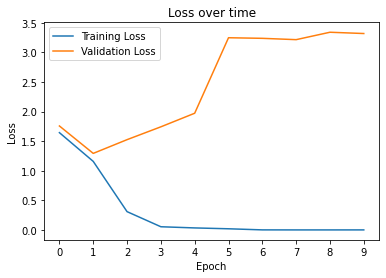

In [20]:
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xticks(range(EPOCHS))
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

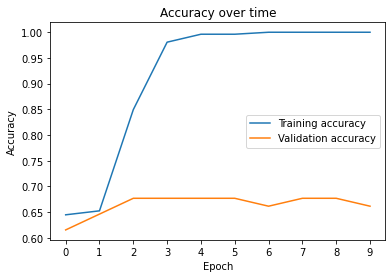

In [21]:
plt.plot(training_accrs, label='Training accuracy')
plt.plot(val_accrs, label='Validation accuracy')
plt.xticks(range(EPOCHS))
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model.eval()
for label_list, text_list, offsets in val_dataloader:
  pred = model(text_list, offsets)
  print(f'{pred=} | {text_list}')
  break

pred=tensor([[1.5677e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>) | tensor([2956, 1947, 3830, 3289,   48, 3610, 2956, 2684,  427, 1758, 4053, 1127,
        2430,   48, 5820, 4362, 6495, 3958, 5251, 4027,   48, 3906,   48, 5820,
        4362, 6495, 3958, 1386, 4048,   49, 2956, 2738, 5903, 5150, 3188,  824,
        5903, 2633, 4851,   68, 3980,   48, 5820, 4362,   28, 2044, 4302, 3202,
        3176, 3958, 6476,   49, 2956, 2798, 5903, 5150, 3188,  824,  561,   68,
        6385, 3188,   28, 6476,   48, 3188,   28, 2700, 1127, 3188, 3176, 6243,
        5788,   68], device='cuda:0')


In [23]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [24]:
notebook.display(port=6006, height=1000) 

<IPython.core.display.Javascript object>